# Pairs Trading Strategy with Statistical Cointegration Filtering

**Author:** Keshav Khandelwal  
**Date:** June 10th, 2025  
**Dataset:** Yahoo Finance – Daily closing prices of US stocks (2018–2023)

---

### Overview

This project implements a **multi-pair statistical arbitrage strategy** using:

- **Rolling z-score** for mean-reversion detection
- **Engle-Granger cointegration test** for filtering stable pairs
- **Sharpe ratio & PnL** as performance metrics
- **Full automation** of pair generation, testing, and backtesting

---

### Key Learning Outcome

The strategy shows how **statistical rigor** prevents overfitting by avoiding trades that appear visually correlated but aren't statistically valid.

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import combinations
from statsmodels.tsa.stattools import coint

**Step 1: Load ETF Data**

In [8]:
tickers = ['KO', 'PEP', 'MSFT', 'AAPL', 'WMT', 'TGT']
data = yf.download(tickers, start="2018-01-01", end="2023-01-01")["Close"]
data = data.dropna()

/tmp/ipython-input-8-3964817113.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2023-01-01")["Close"]
[*********************100%***********************]  6 of 6 completed


**Step 2: Generate Pairs**

In [9]:
pairs = list(combinations(tickers, 2))

**Step 3: Cointegration Test Function using Engle-Granger test**

In [10]:
def is_cointegrated(series_a, series_b, p_thresh=0.15):
    score, pvalue, _ = coint(series_a, series_b)
    return pvalue < p_thresh

**Step 4: Backtesting Function**

In [11]:
def backtest_pair(asset_A, asset_B, window=20, entry_z=1.0, exit_z=0.5, transaction_cost=0.1):
    spread = asset_A - asset_B
    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    zscore = (spread - rolling_mean) / rolling_std

    capital = 0
    position = None
    entry_spread = None
    pnl_log = []

    for i in range(window, len(spread)):
        z = zscore[i]
        if position is None:
            if z > entry_z:
                position = "short_A_long_B"
                entry_spread = spread[i]
            elif z < -entry_z:
                position = "long_A_short_B"
                entry_spread = spread[i]
        elif abs(z) < exit_z:
            exit_spread = spread[i]
            if position == "long_A_short_B":
                profit = exit_spread - entry_spread
            elif position == "short_A_long_B":
                profit = entry_spread - exit_spread
            profit -= transaction_cost
            capital += profit
            pnl_log.append(profit)
            position = None
            entry_spread = None

    if len(pnl_log) < 3:
        return None

    returns = pd.Series(pnl_log)
    sharpe = returns.mean() / returns.std() * np.sqrt(len(returns))
    return {
        'pnl': capital,
        'sharpe': sharpe,
        'trades': len(returns)
    }


**Step 5: Run tests on All Pairs**

In [12]:
results = []

for a, b in pairs:
    if not is_cointegrated(data[a], data[b]):
        continue

    result = backtest_pair(data[a], data[b])
    if result:
        results.append({
            'pair': (a, b),
            **result
        })


/tmp/ipython-input-11-1132766327.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z = zscore[i]
/tmp/ipython-input-11-1132766327.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_spread = spread[i]
/tmp/ipython-input-11-1132766327.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exit_spread = spread[i]
/tmp/ipython-input-11-1132766327.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.

**Step 6: Display Results**

In [13]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='sharpe', ascending=False)

print("Top Performing Pairs by Sharpe Ratio:")
print(df_results.head())

Top Performing Pairs by Sharpe Ratio:
          pair         pnl    sharpe  trades
2  (MSFT, TGT)  161.633946  2.103984     102
0    (KO, PEP)   52.573195  2.050856     106
1  (MSFT, WMT)   87.583193  1.144502     100
3  (AAPL, WMT)  -34.787270 -0.652912      88


**Plot Top Pair**

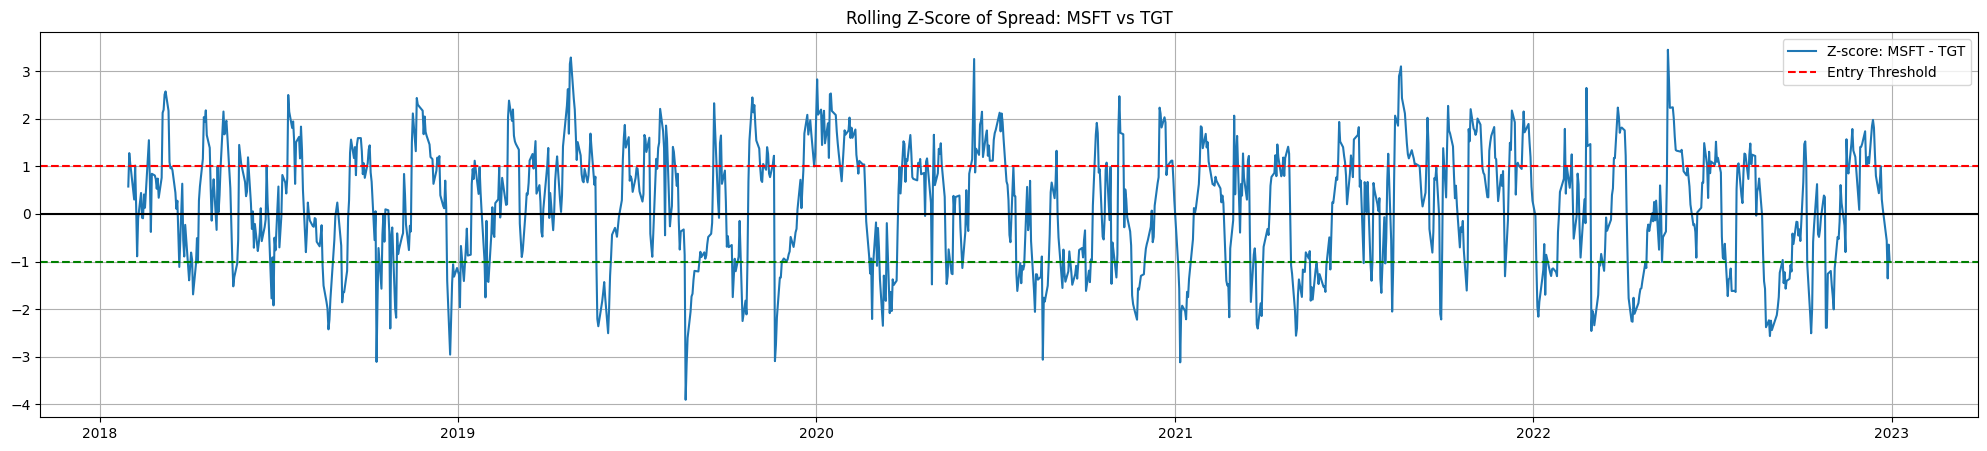

In [17]:
if not df_results.empty:
    top_pair = df_results.iloc[0]['pair']
    a, b = top_pair
    spread = data[a] - data[b]
    rolling_mean = spread.rolling(20).mean()
    rolling_std = spread.rolling(20).std()
    zscore = (spread - rolling_mean) / rolling_std

    plt.figure(figsize=(25, 5))
    plt.plot(zscore, label=f"Z-score: {a} - {b}")
    plt.axhline(1.0, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(-1.0, color='green', linestyle='--')
    plt.axhline(0, color='black', linestyle='-')
    plt.title(f"Rolling Z-Score of Spread: {a} vs {b}")
    plt.legend()
    plt.grid(True)
    plt.show()